# Using PlanarBiaxialExtension

In [1]:
import pymecht as pmt
from matplotlib import pyplot as plt
import numpy as np

## Displacement controlled

We start by using the `PlanarBiaxialExtension` in a simple `disp_controlled` manner. We start by creating a material and using it create an experimental sample. Then, we set it to have two fibers at $\pm 10$ degrees. We also set the parameters, and print the sample and parameter values. 

In [2]:
mat = pmt.MatModel('goh','nh')

sample = pmt.PlanarBiaxialExtension(mat)
pmt.specify_two_fibers(sample,10)
params = sample.parameters
params.set('k1_0',20)
params.set('k2_0',20)
print(sample, params)

Fiber directions set to  10  degrees ( 0.17453292519943295  radians)
An object of type PlanarBiaxialExtensionwith stretch as input, cauchy as output, and the following material
Material model with 2 components:
Component1: GOH with fiber direction(s):[array([0.98480775, 0.17364818, 0.        ]), array([ 0.98480775, -0.17364818,  0.        ])]
Component2: NH with fiber direction(s):[array([0.98480775, 0.17364818, 0.        ]), array([ 0.98480775, -0.17364818,  0.        ])]
 ------------------------------------------------------------------
Keys              Value       Fixed?      Lower bound Upper bound 
------------------------------------------------------------------
L10               1.00        No          1.00e-04    1.00e+03    
L20               1.00        No          1.00e-04    1.00e+03    
thick             1.00        No          1.00e-04    1.00e+03    
k1_0              20.00       No          0.10        30.00       
k2_0              20.00       No          0.10      

By default, the displaement measure (input) is stretch and the force measure (output) is Cauchy stress. Note that for planar biax setup, there are two inputs and two outputs (e.g., stretches and stresses along the two directions). Thus, when we create the displacement to be applied, we create a 2D array, where each row has two elements: stretch along the x-axis and stretch along the y-axis. We set them to increase linearly between unit stretch and a maximum stretch of 1.1 along the x-axis and 1.3 along the y-axis. 

Then, we perform then `disp_controlled` simulation at these stretches. It results in a stress array, which is also 2D, with each row having the stress along x-axis and that along the y-axis. Lastly, we plot the resulting stress-stretch curves along the two directions.

(10, 2) (10, 2)
[1.01111111 1.03333333] [1.08277678 0.20397835]


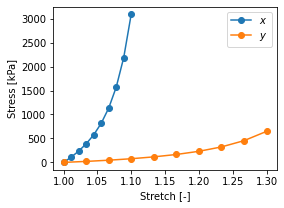

In [3]:
stretch = np.array([np.linspace(1,1.1,10),np.linspace(1,1.3,10)]).T
stress = sample.disp_controlled(stretch,params)
print(stretch.shape, stress.shape) #the shape of input and output arrays
print(stretch[1], stress[1]) #example inputs and outputs

fig,ax = plt.subplots(1,1,figsize=(4,3))
ax.plot(stretch[:,0],stress[:,0]*100,'-o',label=r'$x$')
ax.plot(stretch[:,1],stress[:,1]*100,'-o',label=r'$y$')
ax.set_xlabel('Stretch [-]')
ax.set_ylabel('Stress [kPa]')
plt.legend()
plt.show()

## Force controlled

The inverse of `disp_controlled` is `force_controlled` simulation, wherein we apply a force (or stress) and the result is a stretch (or strain/length etc., depending on the setting when creating a sample). Here, we use the stresses we calculated in the previous step to back calculate the stretch. We check the difference and see that a close-enough solution was found. Note that `force_controlled` uses iterative solver, evaluating the `disp_controlled` simulation multiple times to find the "displacement" that would result in the applied force (numerically close-enough). Thus, `force_controlled` is commonly slower than `disp_controlled`.

In [4]:
stretch_back = sample.force_controlled(stress,params)
print(np.linalg.norm(stretch_back-stretch))

8.503677451570787e-12


## Different `force_measure`s

There are different options for the `force_measure` argument, as we can see from the helper function.

In [5]:
pmt.PlanarBiaxialExtension?

Init signature:
pmt.PlanarBiaxialExtension(
    mat_model,
    disp_measure='stretch',
    force_measure='cauchy',
)
Docstring:     
For simulating planar biaxial extension of a planar sample

+-----------+---------------------------+
| Parameter | Description (default)     |
+===========+===========================+
| L10       | Ref length: 1st axis (1)  |
+-----------+---------------------------+
| L20       | Ref length: 2nd axis (1)  |
+-----------+---------------------------+
| thick     | Sample thicknesse (1)     |
+-----------+---------------------------+


Parameters
----------
mat_model: MatModel
    A material model object of type MatModel

disp_measure: str
    The measure of displacement with the following options:    
    
    * 'stretch' : The stretch ratio (default)
    * 'strain' : The Green-Lagrange strain
    * 'deltal' : The change in length
    * 'length' : The length

force_measure: str
    The measure of force with the following options:
    
    * 'force' : The

In [6]:
#output force
sample = pmt.PlanarBiaxialExtension(mat,force_measure='force')
pmt.specify_two_fibers(sample,10)
print(sample.disp_controlled(stretch,params)) #prints force, which will depend on lengths and thickness
params.set('L10',2)
params.set('L20',2)
params.set('thick',2)
print(sample.disp_controlled(stretch,params)) #see the new force, which should be 4 times

Fiber directions set to  10  degrees ( 0.17453292519943295  radians)
[[ 0.          0.        ]
 [ 1.07087813  0.19739841]
 [ 2.29707897  0.42600305]
 [ 3.73982384  0.6939273 ]
 [ 5.49544981  1.01540952]
 [ 7.71157638  1.41391158]
 [10.61447776  1.92716025]
 [14.55572515  2.61571986]
 [20.09275611  3.57794081]
 [28.13077066  4.97660603]]
[[  0.           0.        ]
 [  4.28351252   0.78959362]
 [  9.18831587   1.70401218]
 [ 14.95929535   2.7757092 ]
 [ 21.98179923   4.0616381 ]
 [ 30.84630553   5.65564632]
 [ 42.45791106   7.70864098]
 [ 58.22290059  10.46287943]
 [ 80.37102445  14.31176324]
 [112.52308264  19.90642412]]


In [7]:
#output tension
sample = pmt.PlanarBiaxialExtension(mat,force_measure='tension')
pmt.specify_two_fibers(sample,10)
params.set('L10',1)
params.set('L20',1)
params.set('thick',1)
print(sample.disp_controlled(stretch,params)) #prints tension, which will depend on thickness, but not lengths
params.set('L10',2)
params.set('L20',2)
print(sample.disp_controlled(stretch,params)) #see the new force, which should be 4 times

Fiber directions set to  10  degrees ( 0.17453292519943295  radians)
[[ 0.          0.        ]
 [ 1.07087813  0.19739841]
 [ 2.29707897  0.42600305]
 [ 3.73982384  0.6939273 ]
 [ 5.49544981  1.01540952]
 [ 7.71157638  1.41391158]
 [10.61447776  1.92716025]
 [14.55572515  2.61571986]
 [20.09275611  3.57794081]
 [28.13077066  4.97660603]]
[[ 0.          0.        ]
 [ 1.07087813  0.19739841]
 [ 2.29707897  0.42600305]
 [ 3.73982384  0.6939273 ]
 [ 5.49544981  1.01540952]
 [ 7.71157638  1.41391158]
 [10.61447776  1.92716025]
 [14.55572515  2.61571986]
 [20.09275611  3.57794081]
 [28.13077066  4.97660603]]


In [8]:
#output 1st PK stress
sample = pmt.PlanarBiaxialExtension(mat,force_measure='1pk')
pmt.specify_two_fibers(sample,10)
params.set('L10',1)
params.set('L20',1)
params.set('thick',1)
print(sample.disp_controlled(stretch,params)) #prints 1st PK stress

Fiber directions set to  10  degrees ( 0.17453292519943295  radians)
[[ 0.          0.        ]
 [ 1.07087813  0.19739841]
 [ 2.29707897  0.42600305]
 [ 3.73982384  0.6939273 ]
 [ 5.49544981  1.01540952]
 [ 7.71157638  1.41391158]
 [10.61447776  1.92716025]
 [14.55572515  2.61571986]
 [20.09275611  3.57794081]
 [28.13077066  4.97660603]]


## Different `disp_measure`s

There are different options for the `disp_measure` argument, as we can see from the helper function. Thus, one can use different ones when creating the sample. This will result in different outputs from `force_controlled`. Similarly, the inputs to the `disp_controlled` will be treated as the chosen `disp_measure`.

When using `force_controlled` simulation, an iterative solution is involved, for which an initial guess is required. There is a default value, which may not be reasonable for different `disp_measure`s. Thus, we explicitly specify the initial guess using `x0` argument.

In [9]:
sample2 = pmt.PlanarBiaxialExtension(mat,disp_measure='strain')
pmt.specify_two_fibers(sample2,10,verbose=False)
result = sample2.force_controlled(stress,params, x0=[0.,0.])
print('strain', result[-1])

sample2 = pmt.PlanarBiaxialExtension(mat,disp_measure='deltal')
pmt.specify_two_fibers(sample2,10,verbose=False)
result = sample2.force_controlled(stress,params, x0=[0.,0.])
print('deltal', result[-1])

sample2 = pmt.PlanarBiaxialExtension(mat,disp_measure='length')
pmt.specify_two_fibers(sample2,10,verbose=False)
result = sample2.force_controlled(stress,params, x0=[params['L10'].value,params['L20'].value])
print('length', result[-1])

strain [0.01 0.09]
deltal [0.1 0.3]
length [1.1 1.3]


## Fiber direction warning

One can manually specify fiber direction in the material models before using them to create a `PlanarBiaxialExtension` sample, as follows.

In [10]:
mat = pmt.MatModel('goh','nh')
mat_models = mat.models
mat_models[0].fiber_dirs = np.array([1,0,0])
sample = pmt.PlanarBiaxialExtension(mat)

However, this makes it possible to create out of plane fiber directions, which can result in erroneous result. Thus, in such situations a warning will be generated.

In [11]:
mat = pmt.MatModel('goh','nh')
mat_models = mat.models
mat_models[0].fiber_dirs = np.array([0.5,0,0.5])
sample = pmt.PlanarBiaxialExtension(mat)

/usr/local/lib/python3.9/site-packages/pymecht/SampleExperiment.py:423: UserWarning: The PlanarBiaxialExtension assumes that fibers are in the plane. This is not satisfied and the results may be spurious.
  warnings.warn("The PlanarBiaxialExtension assumes that fibers are in the plane. This is not satisfied and the results may be spurious.")


Thus, helper functions `specify_single_fiber` and `specify_two_fibers` are provided to avoid such errors.